# AI-Industry: Clean Energy

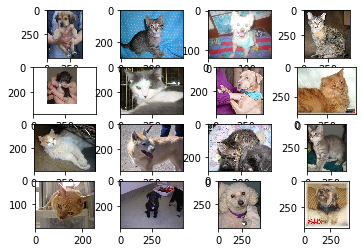

In [46]:
from os import path
from os import listdir
from numpy import asarray
from numpy import save
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from matplotlib import pyplot
from matplotlib.image import imread


def plot_imgs(foler, number):
    filenames = list(os.listdir(folder))
    img_number = number
    filenmaes_part = filenames[:img_number]
    for i,item in enumerate(filenmaes_part):
        # define subplot
        #pyplot.subplot(330 + 1 + i)
        pyplot.subplot(4,4, i+1)
        filename = folder + item
        image = imread(filename)
        pyplot.imshow(image)
    # show the figure
    pyplot.show()
    
src_dir = 'data/train/'
plot_imgs(src_dir,16)  

In [70]:
def imgs_process(img_folder, classification, t_size, photos_npy,img_labels):        
    photos, labels = [],[]
    for file_name in listdir(img_folder):
        # determine class
        output = 0.0
        if file_name.startswith(classification):
            output = 1.0
        # load image
        photo = load_img(img_folder + file_name, target_size=t_size)
        # convert to numpy array
        photo = img_to_array(photo)
        # store
        photos.append(photo)
        labels.append(output)
    # convert to a numpy arrays
    photos = asarray(photos)
    labels = asarray(labels)
    print(photos.shape, labels.shape)
    # save the reshaped photos
    save(photos_npy, photos)
    save(img_labels, labels)
    print('Images preprocessing is done...')
  
imgs_process(src_dir,'cat',(224,224), 'classification_photos.npy', 'classification_labels.npy')

(25000, 224, 224, 3) (25000,)
Images preprocessing is done...


In [48]:
def load_imgs_array(photos_npy,img_labels):
    from numpy import load
    if os.path.exists(photos_npy) and os.path.exists(img_labels):
        print('Loading photos array and labels array...')
        photos = load(photos_npy)
        labels = load(img_labels)
        print('Photos and labels load is done: ',photos.shape, labels.shape)
    else: print('No photos and labels array files, please process it.')
load_imgs_array('classification_photos.npy', 'classification_labels.npy')

Loading photos array and labels array...
Phoots and labels load is done:  (25000, 200, 200, 3) (25000,)


In [56]:
from shutil import copyfile
from random import seed
from random import random
def make_copy_dir(dataset_home,src_directory):
    sub_dirs = ['train/', 'test/']
    for subdir in sub_dirs:
        dirs_label = ['type1/', 'type2/']
        for dir_label in dirs_label:
            newdir = dataset_home + subdir + dir_label
            os.makedirs(newdir, exist_ok=True)
    print('Make new dirs and copy data...')
    # seed random number generator
    seed(1)
    # define ratio of pictures to use for validation
    val_ratio = 0.25
    # copy training dataset images into subdirectories
    for i, file in enumerate(listdir(src_directory)):
        src = src_directory + '/' + file
        dst_dir = 'train/'
        if random() < val_ratio:
            dst_dir = 'test/'
        if file.startswith('cat'):
            file = 'typeI' + str(i) +'.jpg'
            dst = dataset_home + dst_dir + 'type1/'  + file
            copyfile(src, dst)
        elif file.startswith('dog'):
            file = 'typeII' + str(i) +'.jpg'
            dst = dataset_home + dst_dir + 'type2/'  + file
            copyfile(src, dst)
    
    print('Data is ready...')             
dataset_home = 'CleanAIdata/'            
make_copy_dir(dataset_home,src_dir)

Make new dirs and copy data...
Data is ready...


In [81]:
# CNN - 3 layters, baseline model with data augmentation for the typeI vs typeII dataset

import sys
from matplotlib import pyplot
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator

# define cnn model
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = SGD(lr=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model



# run the test harness for evaluating a model
def run_test_harness():
	# define model
	model = define_model()
	# create data generators
	train_datagen = ImageDataGenerator(rescale=1.0/255.0,
		width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
	test_datagen = ImageDataGenerator(rescale=1.0/255.0)
	# prepare iterators
	train_it = train_datagen.flow_from_directory(dataset_home + 'train/',
		class_mode='binary', batch_size=64, target_size=(200, 200))
	test_it = test_datagen.flow_from_directory(dataset_home + 'test/',
		class_mode='binary', batch_size=64, target_size=(200, 200))
	# fit model
	fit_history = model.fit(train_it, steps_per_epoch=len(train_it),
		validation_data=test_it, validation_steps=len(test_it), epochs=1, verbose=1)
	# evaluate model
	_, acc = model.evaluate_generator(test_it, steps=len(test_it), verbose=1)
	print('> %.3f' % (acc * 100.0))
	# learning curves
	return fit_history

# entry point, run the test harness
dataset_home = 'CleanAIdata/'
fit_history = run_test_harness()


Found 18697 images belonging to 2 classes.
Found 6303 images belonging to 2 classes.
99/99 [==============================] - 38s 386ms/step - loss: 0.6436 - accuracy: 0.6261
> 62.605


In [80]:
# plot diagnostic learning curves
def summarize_diagnostics(history):
	# plot loss
	pyplot.subplot(211)
	pyplot.title('Cross Entropy Loss')
	pyplot.plot(history.history['loss'], color='blue', label='train')
	pyplot.plot(history.history['val_loss'], color='orange', label='test')
	# plot accuracy
	pyplot.subplot(212)
	pyplot.title('Classification Accuracy')
	pyplot.plot(history.history['accuracy'], color='blue', label='train')
	pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
	pyplot.show()
	# save plot to file
	filename = sys.argv[0].split('/')[-1]
	pyplot.savefig(filename + '_plot.png')
	pyplot.close()

summarize_diagnostics(fit_history )

NameError: name 'fit_history' is not defined

In [ ]:
# vgg16 model used for transfer learning on the dataset
import sys
from matplotlib import pyplot
from keras.utils import to_categorical
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator

# define cnn model
def define_transfer_model():
	# load model
	model = VGG16(include_top=False, input_shape=(224, 224, 3))
	# mark loaded layers as not trainable
	for layer in model.layers:
		layer.trainable = False
	# add new classifier layers
	flat1 = Flatten()(model.layers[-1].output)
	class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
	output = Dense(1, activation='sigmoid')(class1)
	# define new model
	model = Model(inputs=model.inputs, outputs=output)
	# compile model
	opt = SGD(lr=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model

# run the test harness for evaluating a model
def run_test_harness():
	# define model
	model = define_transfer_model()
	# create data generator
	datagen = ImageDataGenerator(featurewise_center=True)
	# specify imagenet mean values for centering
	datagen.mean = [123.68, 116.779, 103.939]
	# prepare iterators
	train_it = train_datagen.flow_from_directory(dataset_home + 'train/',
		class_mode='binary', batch_size=64, target_size=(224, 224))
	test_it = test_datagen.flow_from_directory(dataset_home + 'test/',
		class_mode='binary', batch_size=64, target_size=(224, 224))
	# fit model
	fit_history = model.fit(train_it, steps_per_epoch=len(train_it),
		validation_data=test_it, validation_steps=len(test_it), epochs=1, verbose=1)
	# evaluate model
	_, acc = model.evaluate_generator(test_it, steps=len(test_it), verbose=1)
	print('> %.3f' % (acc * 100.0))
	# learning curves
	return fit_history

# entry point, run the test harness
dataset_home = 'CleanAIdata/'
fit_history = run_test_harness()

In [ ]:
summarize_diagnostics(fit_history)